In [1]:
import numpy as np
from sndaq.analysis import AnalysisHandler, AnalysisConfig

## Setup Analyses and Storage

In [2]:
ana_conf = AnalysisConfig.from_config(conf_path='../../data/config/analysis.config')
ana = AnalysisHandler(config=ana_conf)

ndom = 5160
nbins_window = 400  # 200 s of rates in 0.5s bins
nbins_trigger = int((ana.config.duration_nosearch + 3*max(ana._binnings)) / 500 - 1)
nbins_fill_trailing = nbins_trigger - int(ana.config.duration_nosearch/2 /500)
nbins_fill_leading = nbins_trigger - nbins_fill_trailing - nbins_window

dom_bkg_mu = 140
dom_bkg_sig = 22

rate_500ms = np.zeros(shape=(nbins_window, ndom), dtype=np.uint16)
signi = np.zeros(shape=(nbins_window, len(ana.analyses)), dtype=float)

filler = None
np.random.seed(42)

## Generate samples

In [3]:
n_samples = 10
xi = np.zeros(n_samples)
for idx in range(n_samples):

    # Feed bins ahead of followup window
    for i in range(nbins_fill_trailing):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses()

    # Feed bins of followup window (100 s)
    for i in range(nbins_window):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses()

    # Feed bins to align followup window with PySNDAQ's search windows
    for i in range(nbins_fill_leading):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses()

    # Feed followup window through PySNDAQ's search window (Generate the TS)
    for i in range(nbins_window):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses()

        for j, analysis in enumerate(ana.analyses):
            signi[i, j]  = analysis.xi    
    xi[idx] = signi.max()

## Plot Results

Text(0.5, 1.0, 'Fit Results: $\\mu$=3.08, $\\sigma$=0.26')

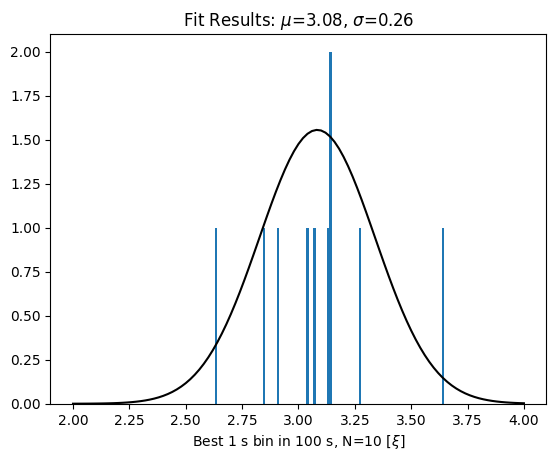

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean,std=norm.fit(xi)
x = np.linspace(2,4, 101)

plt.hist(xi, bins=100)
plt.plot(x, norm.pdf(x, loc=mean, scale=std), 'k')
plt.xlabel(fr"Best 1 s bin in 100 s, N={n_samples} [$\xi$]")
plt.title(fr"Fit Results: $\mu$={mean:4.2f}, $\sigma$={std:4.2f}")

## Profiling

Done with `%%timeit` IPython Magic function

With `binnings = [1000]` (2 binned analyses):
```
- 786 ms ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

With default, `binnings = [500, 1500, 4000, 10000]` (32 binned analyses):
```
- 4.21 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [5]:
t_per_sample = 0.786  # seconds
runtime = t_per_sample * n_samples  # This is an estimate
ratio = runtime / ana.current_time

print(f"Real time: {runtime:.4f} s")
print(f"Processed time: {ana.current_time} s")
print(f"RtP Ratio: {ratio:.4f}")  # Ratio of real time to processed time, smaller is better

Real time: 7.8600 s
Processed time: 8895.0 s
RtP Ratio: 0.0009


## Debug

In [6]:
for i, (analysis, xi) in enumerate(zip(ana.analyses, signi.T), start=1):
    print(f"\nSearch #{i:<2d}: {analysis.binsize/1e3:<4.1f} +{analysis.offset/1e3:<4.1f}s\n"
          f"   max xi : {xi.max():4.2f}  @ bin t={xi.argmax()*0.5}s from window start")


Search #1 : 0.5  +0.0 s
   max xi : 2.83  @ bin t=98.5s from window start

Search #2 : 1.5  +0.0 s
   max xi : 2.81  @ bin t=171.0s from window start

Search #3 : 1.5  +0.5 s
   max xi : 2.51  @ bin t=99.0s from window start

Search #4 : 1.5  +1.0 s
   max xi : 2.71  @ bin t=16.5s from window start

Search #5 : 4.0  +0.0 s
   max xi : 1.85  @ bin t=172.5s from window start

Search #6 : 4.0  +0.5 s
   max xi : 1.66  @ bin t=96.5s from window start

Search #7 : 4.0  +1.0 s
   max xi : 2.09  @ bin t=96.5s from window start

Search #8 : 4.0  +1.5 s
   max xi : 1.85  @ bin t=188.5s from window start

Search #9 : 4.0  +2.0 s
   max xi : 1.90  @ bin t=100.5s from window start

Search #10: 4.0  +2.5 s
   max xi : 2.47  @ bin t=176.5s from window start

Search #11: 4.0  +3.0 s
   max xi : 3.07  @ bin t=176.5s from window start

Search #12: 4.0  +3.5 s
   max xi : 2.57  @ bin t=176.5s from window start

Search #13: 10.0 +0.0 s
   max xi : 1.38  @ bin t=174.5s from window start

Search #14: 10.0

## Sanity checks on background mean and rate variance (USE AS UNITTEST)

In [7]:
buffer = ana.buffer_analysis.data
for i, search in enumerate(ana.analyses, start=1):
    idx_bg = np.hstack([
        np.arange(search.idx_bgl, search.idx_eod),
        np.arange(search.idx_bgt, search.idx_ext)
    ])
    rebin = np.sum(np.split(buffer[idx_bg], search.nbin_bg), axis=1)
    print(f"\nSearch #{i:<2d}:{search.binsize/1e3:4.1f} +{search.offset/1e3:<4.1f}s")
    print(f"rebin mean: {rebin.mean():7.4f}, rebin var: {rebin.var(axis=0).mean():7.4f}\n"
          f"  ana mean: {search.mean.mean():7.4f},   ana var: {search.var.mean():7.4f}\n")


Search #1 : 0.5 +0.0 s
rebin mean: 139.5158, rebin var: 483.5140
  ana mean: 139.5158,   ana var: 483.5140


Search #2 : 1.5 +0.0 s
rebin mean: 418.5471, rebin var: 1448.6591
  ana mean: 418.5471,   ana var: 1448.6591


Search #3 : 1.5 +0.5 s
rebin mean: 418.5476, rebin var: 1448.2551
  ana mean: 418.5476,   ana var: 1448.2551


Search #4 : 1.5 +1.0 s
rebin mean: 418.5500, rebin var: 1449.7808
  ana mean: 418.5500,   ana var: 1449.7808


Search #5 : 4.0 +0.0 s
rebin mean: 1116.1261, rebin var: 3839.3544
  ana mean: 1116.1302,   ana var: 3846.6639


Search #6 : 4.0 +0.5 s
rebin mean: 1116.1288, rebin var: 3839.9517
  ana mean: 1116.1337,   ana var: 3844.6450


Search #7 : 4.0 +1.0 s
rebin mean: 1116.1361, rebin var: 3848.5830
  ana mean: 1116.1323,   ana var: 3840.5538


Search #8 : 4.0 +1.5 s
rebin mean: 1116.1347, rebin var: 3847.0390
  ana mean: 1116.1305,   ana var: 3840.2579


Search #9 : 4.0 +2.0 s
rebin mean: 1116.1327, rebin var: 3851.8273
  ana mean: 1116.1377,   ana var: 3848

In [8]:
for i, search in enumerate(ana.analyses):
    idc_debug = {
        'eod': search.idx_eod,
        'bgl': search.idx_bgl,
        'exl': search.idx_exl,
        'sw':  search.idx_sw,
        'ext': search.idx_ext,
        'bgt': search.idx_bgt
    }
    
    print(f"\nSearch #{i:<2d} :{search.binsize/1e3:4.1f} +{search.offset/1e3:<4.1f}s")
    for key, val in idc_debug.items():
        print(f"{key:>10s} : {val:<5d}")


Search #0  : 0.5 +0.0 s
       eod : 1379 
       bgl : 779  
       exl : 719  
        sw : 718  
       ext : 658  
       bgt : 58   

Search #1  : 1.5 +0.0 s
       eod : 1379 
       bgl : 779  
       exl : 719  
        sw : 716  
       ext : 656  
       bgt : 56   

Search #2  : 1.5 +0.5 s
       eod : 1378 
       bgl : 778  
       exl : 718  
        sw : 715  
       ext : 655  
       bgt : 55   

Search #3  : 1.5 +1.0 s
       eod : 1377 
       bgl : 777  
       exl : 717  
        sw : 714  
       ext : 654  
       bgt : 54   

Search #4  : 4.0 +0.0 s
       eod : 1379 
       bgl : 779  
       exl : 719  
        sw : 711  
       ext : 651  
       bgt : 51   

Search #5  : 4.0 +0.5 s
       eod : 1378 
       bgl : 778  
       exl : 718  
        sw : 710  
       ext : 650  
       bgt : 50   

Search #6  : 4.0 +1.0 s
       eod : 1377 
       bgl : 777  
       exl : 717  
        sw : 709  
       ext : 649  
       bgt : 49   

Search #7  : 4.0 +1.5 s
  